In [0]:
# Library Dependencies
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [0]:
# convert rgb to grayscale and use Otsu's binarization thresholding to identify "foreground" and "background"
def otsu_binarization(img):
    gray_scale_img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)  # convert to grayscale
    _, binarized_img = cv.threshold(gray_scale_img,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)  # apply Otsu's binarization thresholding
    return binarized_img

In [0]:
# uses distance transform and dilate to further separate binarized foreground and background regions
def foreground_background(img):
    kernel = np.ones((3,3),np.uint8)
    
    # remove noise by filling up morphological holes
    opening = cv.morphologyEx(img,cv.MORPH_OPEN,kernel, iterations = 2)
    
    # use dilation to expand foreground and identify definite background
    background = cv.dilate(opening,kernel,iterations=3)
    
    # use distance transform with thresholding to identify definite foreground
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
    _, foreground = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    
    # remove definite foreground from expanded foreground to identify unknown region
    foreground = np.uint8(foreground)
    unknown = cv.subtract(background,foreground)
    
    return foreground, background, unknown

In [0]:
# separate foreground into connected components
def connected_markers(img, unknown):
    ret, markers = cv.connectedComponents(img)
    markers = markers+1  # start counting definite regions from 1
    markers[unknown==255] = 0  # set unknown regions to 0
    
    return markers

In [0]:
# plots two images side by side for comparison
def compare_img(a, b):
    plt.subplot(1, 2, 1)
    plt.imshow(a, zorder=1)
    plt.subplot(1, 2, 2)
    plt.imshow(b, alpha=1, zorder=2)
    plt.show()
    plt.clf()

In [0]:
# creates mask matching specified value
def generate_mask(arr, idx):
    mask = np.zeros((arr.shape))
    mask[arr == idx] = 1
    mask = np.expand_dims(mask, axis=-1)
    mask = np.tile(mask, 3)
    
    return mask

In [0]:
# returns a matrix of weights with a central peak
def get_central_weight(width, height):
    central_weights = np.ones((width, height))
    center_x, center_y = int(width/2), int(height/2)
    max_x_dist, max_y_dist = max(center_x-0, width-center_x), max(center_y-0, height-center_y)
    
    for x in range(width):
        for y in range(height):
            x_dist, y_dist = abs(x-center_x), abs(y-center_y)  # using L1 norm
            normalized_x_dist, normalized_y_dist = x_dist/max_x_dist, y_dist/max_y_dist
            normalized_dist = max(normalized_x_dist, normalized_y_dist)
            central_weights[x][y] -= normalized_dist
    
    return central_weights

In [0]:
# calculates a central tendency score for each mask, and outputs the most central one
def get_prominent_mask(arr):
    width = arr.shape[0]
    height = arr.shape[1]
    
    # get all unique marker indices
    seg_indices = set(arr.flatten())
    seg_indices.remove(-1)  # -1 is used for boundaries
    seg_count = len(seg_indices)
    
    # generate central weights
    central_weights = get_central_weight(width, height)
    
    # calculate each segments prominence score
    seg_score = np.zeros((seg_count))
    seg_masks = np.zeros((seg_count,width,height), dtype=np.int)

    for seg_idx in seg_indices:
        seg_masks[seg_idx-1] = np.where(arr == seg_idx, 1, 0)
        
        weighted_seg = np.multiply(seg_masks[seg_idx-1], central_weights)
#         seg_score[seg_idx-1] = weighted_seg.sum() / np.sqrt(seg_masks[seg_idx-1].sum())  # divide obtained score by sqrt of number of pixels
#         seg_score[seg_idx-1] = weighted_seg.sum() / np.log(seg_masks[seg_idx-1].sum())  # divide obtained score by log of number of pixels
        seg_score[seg_idx-1] = weighted_seg.sum() / seg_masks[seg_idx-1].sum()  # divide obtained score by sum of number of pixels

    # identify mask for most prominent segment
    prominent_idx = np.argmax(seg_score)
    image_mask = seg_masks[prominent_idx]
    image_mask = np.expand_dims(image_mask,-1)
    return image_mask

In [0]:
# finds the prominent segment in image at given path using Watershed Algorithm Model
def watershed_model(path):
    # note: part of this watershed model follows
    # the OpenCV tutorial titled "Image Segmentation with Watershed Algorithm"
    # Can be found at: https://docs.opencv.org/3.4.3/d3/db4/tutorial_py_watershed.html

    # load image file
    bgr_img = cv.imread(path)  # openCV reads in BGR format
    b,g,r = cv.split(bgr_img)
    rgb_img = cv.merge([r,g,b])  # switch it to rgb

    # extract foreground and background
    binarized_img = otsu_binarization(bgr_img)
    foreground, background, unknown = foreground_background(binarized_img)

    # generate markers for connected regions
    markers = connected_markers(foreground, unknown)

    # apply watershed algorithm to find segment boundaries
    markers = cv.watershed(bgr_img, markers)

    # display original image vs segmented markers
    compare_img(rgb_img, markers)

    # get mask for segment with greatest central prominence (this is the "output" of this watershed model)
    mask = get_prominent_mask(markers)

    # apply mask and display image
    masked_img = np.zeros((rgb_img.shape), dtype=np.uint8)
    masked_img = np.where(mask, rgb_img, masked_img)

    # highlight segment broundaries with red
    segmented_img = rgb_img.copy()
    segmented_img[markers == -1] = [255,0,0]

    # display prominence mask vs masked image
    compare_img(segmented_img, masked_img)
    
    return mask

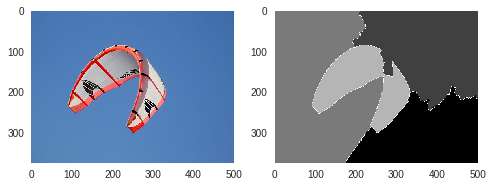

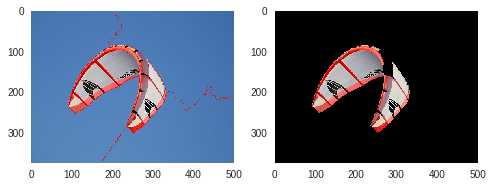

<Figure size 576x396 with 0 Axes>

In [10]:
output_mask = watershed_model('000000007784.jpg')